In [1]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()

In [3]:
len(words)

32033

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [5]:
vocab_size = len(itos)
print(vocab_size)

27


In [6]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [36]:
# MLP 
n_embd = 10 # dim of charactor embedding vector 
n_hidden = 200 # the number of neuron in the hidden layer 

g = torch.Generator().manual_seed(2147483647)               # for reproducibility
C = torch.randn((vocab_size,n_embd),generator=g)            # charactor embedding matrix 
W1 = torch.randn((n_embd*block_size,n_hidden),generator=g)  # wieghts for first hidden layer
b1 = torch.randn(n_hidden,generator=g)                      # first hidden layer biases 
W2 = torch.randn(n_hidden,vocab_size,generator=g)           # output layer weights 
b2 = torch.randn(vocab_size,generator=g)                    # output layer biases 

parameters = [C,W1,b1,W2,b2]                                # parameter list 
print(sum(p.nelement() for p in parameters))                # total number of parameters 

for p in parameters:                                        # turn on the gradient tracking of parameters 
    p.requires_grad = True

11897


In [39]:
# trianing of MLP 
max_steps = 200000
batch_size = 32 
lossi = []

for i in range(max_steps):
    # mini batch creation 
    ix = torch.randint(0,Xtr.shape[0],(batch_size,),generator=g)
    Xb,Yb = Xtr[ix],Ytr[ix]
    
    # forward pass 
    emb = C[Xb]     # shape(32,3,10)
    embcat = emb.view(emb.shape[0],-1) # shape (32,30)->concat the vectors 
    
    # linear layer 
    hpreact = embcat @ W1 + b1        # hidden layer pre-activation 
    
    # non-linearity 
    h = torch.tanh(hpreact)           # putput of the hidden layer
    logits = h @ W2 + b2              # logits (this is the output of the final linear layer) of the NN 
    loss = F.cross_entropy(logits,Yb) # cross entropy loss 
    
    # backward pass 
    for p in parameters:
        p.grad = None                 # initialize the grad to none 
    loss.backward()                   # get the gradient of loss wrt parameters 
    
    # update the weights 
    lr = 0.1 if i < 10000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
    
    # treck the stats 
    if i % 10000 ==0:
        print(f'{i:7d}:{loss.item():.4f}')
    
    lossi.append(loss.log10().item())


      0:24.0032
  10000:2.2132
  20000:2.1788
  30000:2.2213
  40000:2.1876
  50000:2.1890
  60000:2.3193
  70000:2.4592
  80000:2.5209
  90000:2.2868
 100000:2.2681
 110000:2.0074
 120000:2.3041
 130000:2.1750
 140000:1.8488
 150000:2.7004
 160000:2.4313
 170000:1.8341
 180000:1.9799
 190000:2.0921


In [40]:
# test the model in the validation data set (note: we are removing the gradient tracking here)
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train':(Xtr,Ytr),
        'val':(Xdev,Ydev),
        'test':(Xte,Yte)
    }[split]
    
    emb = C[x]                         # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0],-1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1         # (N,n_hidden)
    h = torch.tanh(hpreact)
    logits = h@ W2 + b2 
    loss = F.cross_entropy(logits,y)
    print(split,loss.item())
    
split_loss('train')
split_loss('val')

train 2.2306573390960693
val 2.2488489151000977


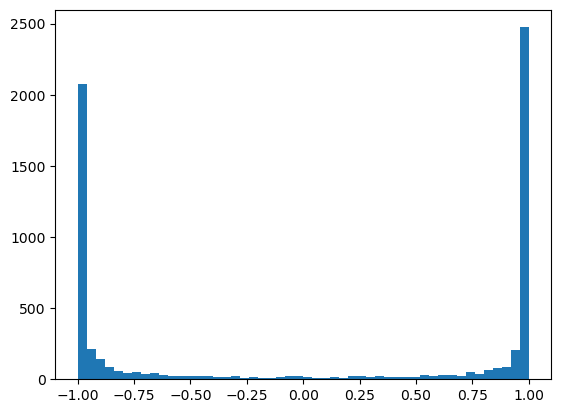

In [41]:
# let's plot the values after tanh activation 
# as you can see most of the values are near either -1 or +1 (and so slow gradient update)
# also note that, when the h-pre-activation is 0, the tanh() activation is zero

plt.hist(h.view(-1).tolist(),50)
plt.show()

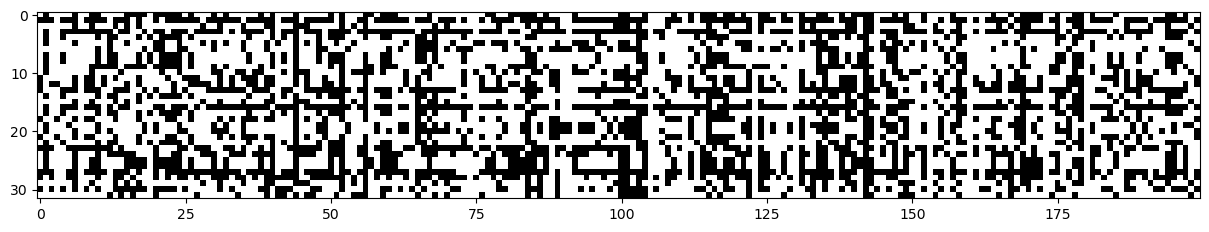

In [42]:
''' 1. extreme hidden layer values (after tanh-activation) are in white -> so gradient updates are slow -> 
   the entire colomn is white its a dead neuron

   2. raws are the batch size (32 examples) and columns are the hidden layer neurons ''' 

plt.figure(figsize=(15,10))
plt.imshow(h.abs() > 0.99, cmap='gray',interpolation='nearest')